# Machine Learning Assignment 04: Decision Trees

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_style('whitegrid')

# Task 1: Preprocessing

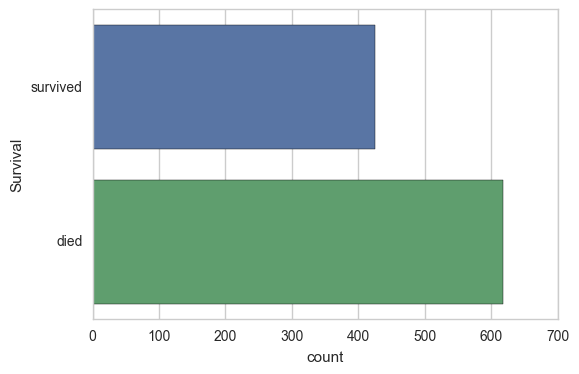

In [32]:
# removing not defined values
titanic_df = pd.read_csv("data.csv")
titanic_df.drop(titanic_df.columns[[0]], axis=1, inplace=True)
titanic_df.replace(' ?', np.nan, inplace=True)
titanic_df = titanic_df.dropna()

# Stripping whitespace
for i in titanic_df:
    titanic_df[i] = titanic_df[i].map(lambda x: x.lstrip(' ').rstrip(' ') if isinstance(x, str) else x)

plot_df = titanic_df.copy()

# Handling categorical values (replace by numerical values)
# Sex: Male = 0, Female = 1
titanic_df.replace('male', 0, inplace=True)
titanic_df.replace('female', 1, inplace=True)

# embarked: S = 0, C = 1, Q = 2
titanic_df.replace('S', 0, inplace=True)
titanic_df.replace('C', 1, inplace=True)
titanic_df.replace('Q', 2, inplace=True)

plot_df['survived'].replace(0, 'died', inplace=True)
plot_df['survived'].replace(1, 'survived', inplace=True)

# plot survival count
ax = sns.countplot(y="survived", data=plot_df)
ax.set(ylabel='Survival')
plt.show()

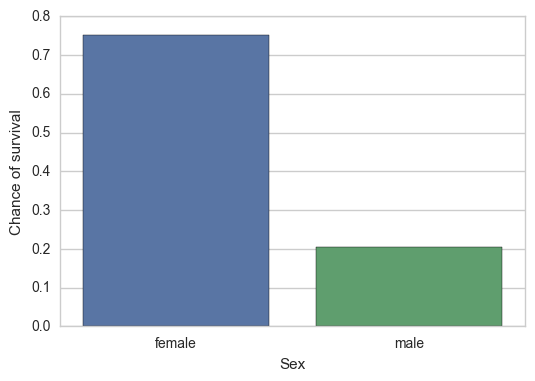

In [33]:
plot_df['survived'].replace('died', 0, inplace=True)
plot_df['survived'].replace('survived', 1, inplace=True)

# chance of survival by sex
survival_by_sex = plot_df[["sex", "survived"]].groupby(['sex'], as_index=False).mean()
ax = sns.barplot(x="sex", y="survived", data=survival_by_sex)
ax.set(xlabel="Sex", ylabel="Chance of survival")
plt.show()

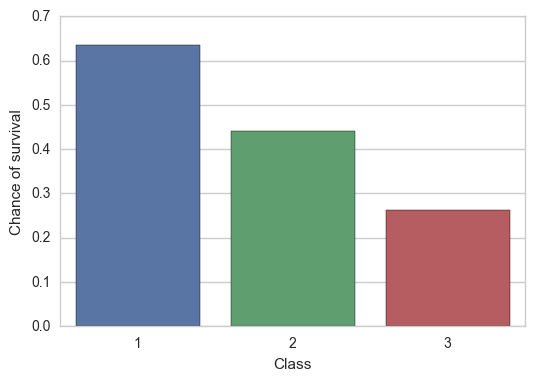

In [34]:
# chance of survival by class
survival_by_class = plot_df[["pclass", "survived"]].groupby(['pclass'], as_index=False).mean()
ax = sns.barplot(x="pclass", y="survived", data=survival_by_class)
ax.set(xlabel="Class", ylabel="Chance of survival")
plt.show()

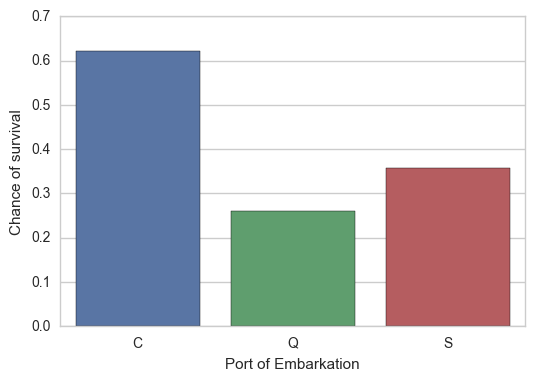

In [35]:
# survival by port of embarkation
survival_by_embarked = plot_df[["embarked", "survived"]].groupby(['embarked'], as_index=False).mean()
ax = sns.barplot(x="embarked", y="survived", data=survival_by_embarked)
ax.set(xlabel="Port of Embarkation", ylabel="Chance of survival")
plt.show()

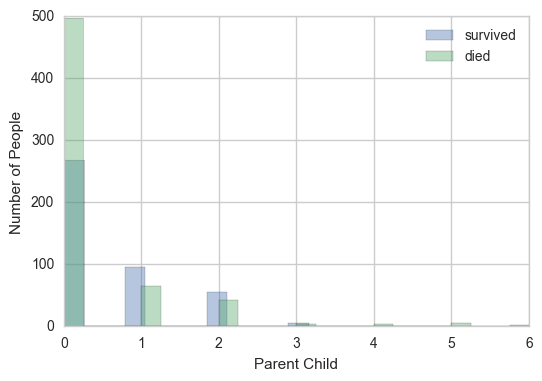

In [36]:
plot_df['survived'].replace(0, 'died', inplace=True)
plot_df['survived'].replace(1, 'survived', inplace=True)

# plot parch
sns.distplot(plot_df['parch'].loc[plot_df['survived'] == 'survived'], label='survived', kde=False)
sns.distplot(plot_df['parch'].loc[plot_df['survived'] == 'died'], label='died', kde=False)
plt.xlabel("Parent Child")
plt.ylabel("Number of People")
plt.legend()
plt.show()

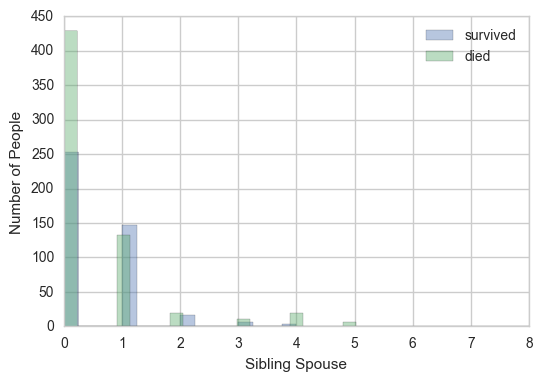

In [37]:
# plot sibsp
sns.distplot(plot_df['sibsp'].loc[plot_df['survived'] == 'survived'], label='survived', kde=False)
sns.distplot(plot_df['sibsp'].loc[plot_df['survived'] == 'died'], label='died', kde=False)
plt.xlabel("Sibling Spouse")
plt.ylabel("Number of People")
plt.legend()
plt.show()

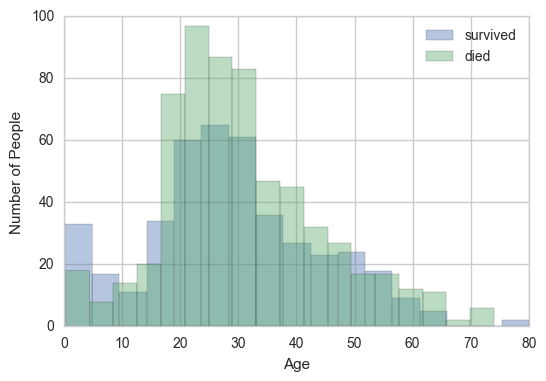

In [38]:
# plot age
sns.distplot(plot_df['age'].loc[plot_df['survived'] == 'survived'], label='survived', kde=False)
sns.distplot(plot_df['age'].loc[plot_df['survived'] == 'died'], label='died', kde=False)
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.legend()
plt.show()

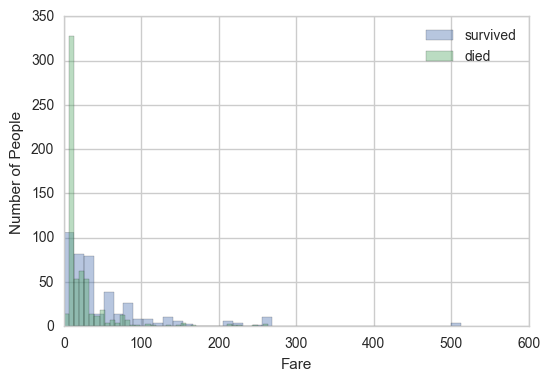

In [39]:
# plot fare
sns.distplot(plot_df['fare'].loc[plot_df['survived'] == 'survived'], label='survived', kde=False, bins=40)
sns.distplot(plot_df['fare'].loc[plot_df['survived'] == 'died'], label='died', kde=False, bins=40)
plt.xlabel("Fare")
plt.ylabel("Number of People")
plt.legend()
plt.show()

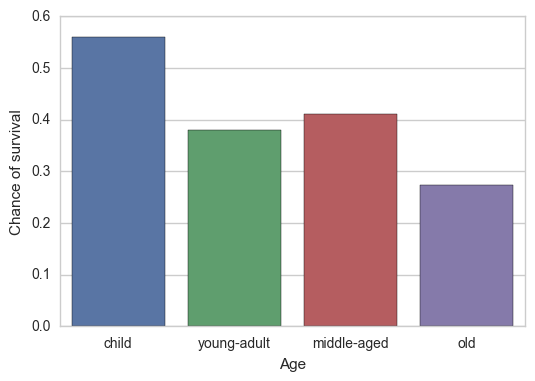

In [10]:
# Categorize Age
plot_df.loc[plot_df['age'] < 15, 'age'] = 0
plot_df.loc[(plot_df['age'] >= 15) & (plot_df['age'] < 32), 'age'] = 1
plot_df.loc[(plot_df['age'] >= 32) & (plot_df['age'] < 63), 'age'] = 2
plot_df.loc[plot_df['age'] >= 63, 'age'] = 3
plot_df['age'].replace(0, "child", inplace=True)
plot_df['age'].replace(1, "young-adult", inplace=True)
plot_df['age'].replace(2, "middle-aged", inplace=True)
plot_df['age'].replace(3, "old", inplace=True)

plot_df['survived'].replace('died', 0, inplace=True)
plot_df['survived'].replace('survived', 1, inplace=True)

# chance of survival by age
survival_by_age = plot_df[["age", "survived"]].groupby(['age'], as_index=False).mean()
ax = sns.barplot(x="age", y="survived", data=survival_by_age, order=['child', 'young-adult', 'middle-aged', 'old'])
ax.set(xlabel="Age", ylabel="Chance of survival")
plt.show()

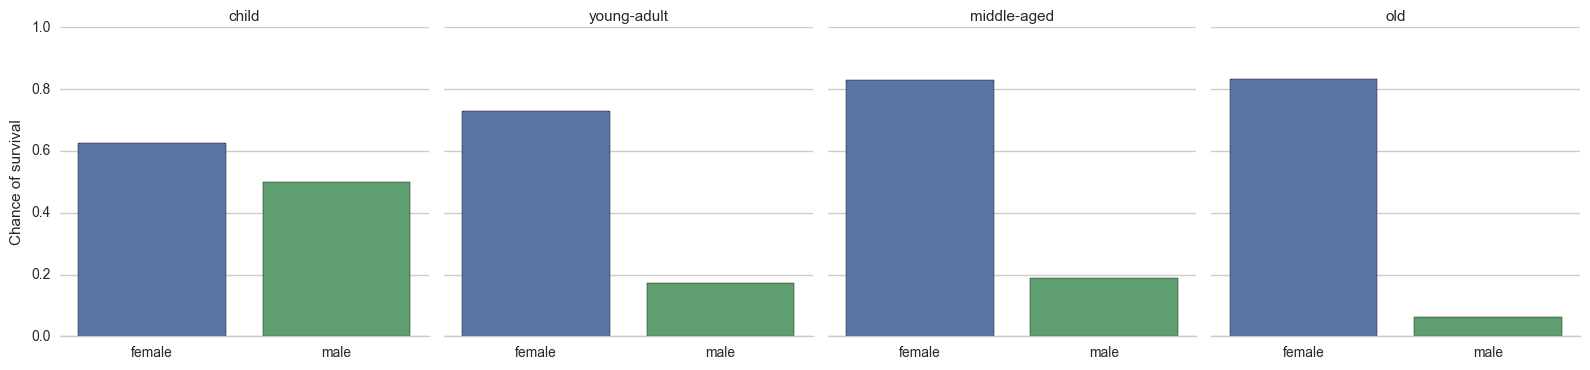

In [11]:
# grouped by age
ax = sns.factorplot(x="sex", y="survived", col="age", data=plot_df, kind="bar",
                    ci=None, col_order=['child', 'young-adult', 'middle-aged', 'old'])
ax.set_axis_labels("", "Chance of survival").set_titles("{col_name}").set(ylim=(0, 1)).despine(left=True)
sns.plt.show()

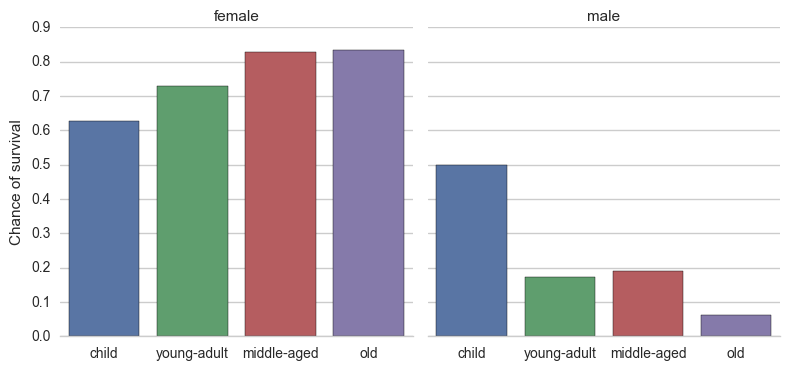

In [12]:
# grouped by sex
ax = sns.factorplot(x="age", y="survived", col="sex", data=plot_df, kind="bar",
                    ci=None, order=['child', 'young-adult', 'middle-aged', 'old'])
ax.set_axis_labels("", "Chance of survival").set_titles("{col_name}").despine(left=True)
sns.plt.show()

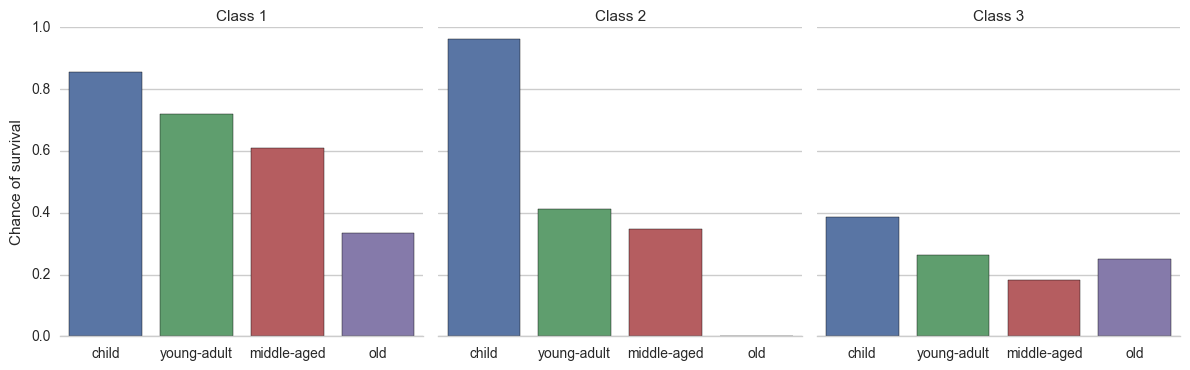

In [13]:
# grouped by class
ax = sns.factorplot(x="age", y="survived", col="pclass", data=plot_df, kind="bar",
                    ci=None, order=['child', 'young-adult', 'middle-aged', 'old'])
ax.set_axis_labels("", "Chance of survival").set_titles("Class {col_name}").despine(left=True)
sns.plt.show()

In [14]:
# create categorical dataframe
titanic_categorical = plot_df.copy()
titanic_categorical['survived'].replace(0, 'died', inplace=True)
titanic_categorical['survived'].replace(1, 'survived', inplace=True)

# categorize fare
titanic_categorical['fare'] = titanic_categorical['fare']
titanic_categorical.loc[(titanic_categorical['fare'] < 6), 'fare'] = 0
titanic_categorical.loc[(titanic_categorical['fare'] >= 6) & (titanic_categorical['fare'] <= 13), 'fare'] = 1
titanic_categorical.loc[(titanic_categorical['fare'] > 13) & (titanic_categorical['fare'] <= 32), 'fare'] = 2
titanic_categorical.loc[(titanic_categorical['fare'] > 32) & (titanic_categorical['fare'] <= 260), 'fare'] = 3
titanic_categorical.loc[(titanic_categorical['fare'] > 260), 'fare'] = 4
titanic_categorical['fare'].replace(0, "low-range", inplace=True)
titanic_categorical['fare'].replace(1, "mid-range", inplace=True)
titanic_categorical['fare'].replace(2, "high-range", inplace=True)
titanic_categorical['fare'].replace(3, "high-range2", inplace=True)

# categorize age and fare for numeric dataframe
titanic_numeric = titanic_df.copy()
titanic_numeric.loc[titanic_numeric['age'] < 9, 'age'] = 0
titanic_numeric.loc[(titanic_numeric['age'] >= 9) & (titanic_numeric['age'] < 32), 'age'] = 1
titanic_numeric.loc[(titanic_numeric['age'] >= 32) & (titanic_numeric['age'] < 74), 'age'] = 2
titanic_numeric.loc[titanic_numeric['age'] >= 74, 'age'] = 3
titanic_numeric.loc[(titanic_numeric['fare'] <= 5), 'fare'] = 0
titanic_numeric.loc[(titanic_numeric['fare'] > 15) & (titanic_numeric['fare'] <= 52), 'fare'] = 1
titanic_numeric.loc[titanic_numeric['fare'] > 52, 'fare'] = 2

# categorize parch
titanic_numeric.loc[titanic_numeric['parch'] > 0, 'parch'] = 1
titanic_categorical.loc[titanic_categorical['parch'] > 0, 'parch'] = 1

# categorize sibsp
titanic_numeric.loc[titanic_numeric['sibsp'] >= 2, 'sibsp'] = 2
titanic_categorical.loc[titanic_categorical['sibsp'] >= 2, 'sibsp'] = 2

## Short summary of our observation:
- Feature "sex" is very important -> women have a significant chance of survival (plot)
- Children have a higher chance of survival
    - but children's survival chances do not depend on sex as opposed to adults
    - this confirms the saying "Women and children first"
    - another anomaly: Children in class 2 have higher survival chances than in class 1/3
- Feature "age" is important -> the younger, the higher the survival chances
- Passenger class is also important: Class 1 Passengers survive more often 

# Task 2
## Decision Tree Classifier on given data

### Grid Search
**Tuning hyper-parameters for accuracy**

In [15]:
def grid_search(classifier, data, results):
    param_grid = [
        {'min_samples_split': range(2, 6),
         'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 10), 'presort': [0, 1]
         }
    ]
    clf = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')
    clf.fit(data, results)
    print("Best parameters found:")
    print(clf.best_params_)
    return clf.best_params_


def cross_val(classifier, splits, data, results):
    skf = StratifiedKFold(n_splits=splits)
    scores = np.array([])
    aggregated_classifier_results = np.array([])
    aggregated_results = np.array([])
    for train, test in skf.split(data, results):
        data_train = data.iloc[train]
        results_train = results.iloc[train]
        data_test = data.iloc[test]
        results_test = results.iloc[test]
        aggregated_results = np.append(aggregated_results, results_test)
        classifier.fit(data_train, results_train)
        classifier_result = dt.predict(data_test)
        aggregated_classifier_results = np.append(aggregated_classifier_results, classifier_result)
        score = accuracy_score(results_test, classifier_result)
        scores = np.append(scores, score)
    print("Accuracy: {0:.2f} (+/- {1:.2f})".format(scores.mean(), scores.std()))
    print(classification_report(aggregated_results, aggregated_classifier_results))
    
# given data
features = list(titanic_df.columns[1:])
titanic_y = titanic_df["survived"]
titanic_X = titanic_df[features]

dt = DecisionTreeClassifier()
dt.set_params(**grid_search(dt, titanic_X, titanic_y))

Best parameters found:
{'criterion': 'entropy', 'min_samples_leaf': 8, 'min_samples_split': 2, 'presort': 0}


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0, presort=0,
            random_state=None, splitter='best')

### Cross-Validation

In [16]:
cross_val(dt, 10, titanic_X, titanic_y)

dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=features,
                                class_names=["died", "survived"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

Accuracy: 0.76 (+/- 0.10)
             precision    recall  f1-score   support

        0.0       0.80      0.80      0.80       618
        1.0       0.71      0.71      0.71       425

avg / total       0.77      0.77      0.77      1043



True

### Tree structure of the sklearn Decision Tree on given data
**double click to zoom**

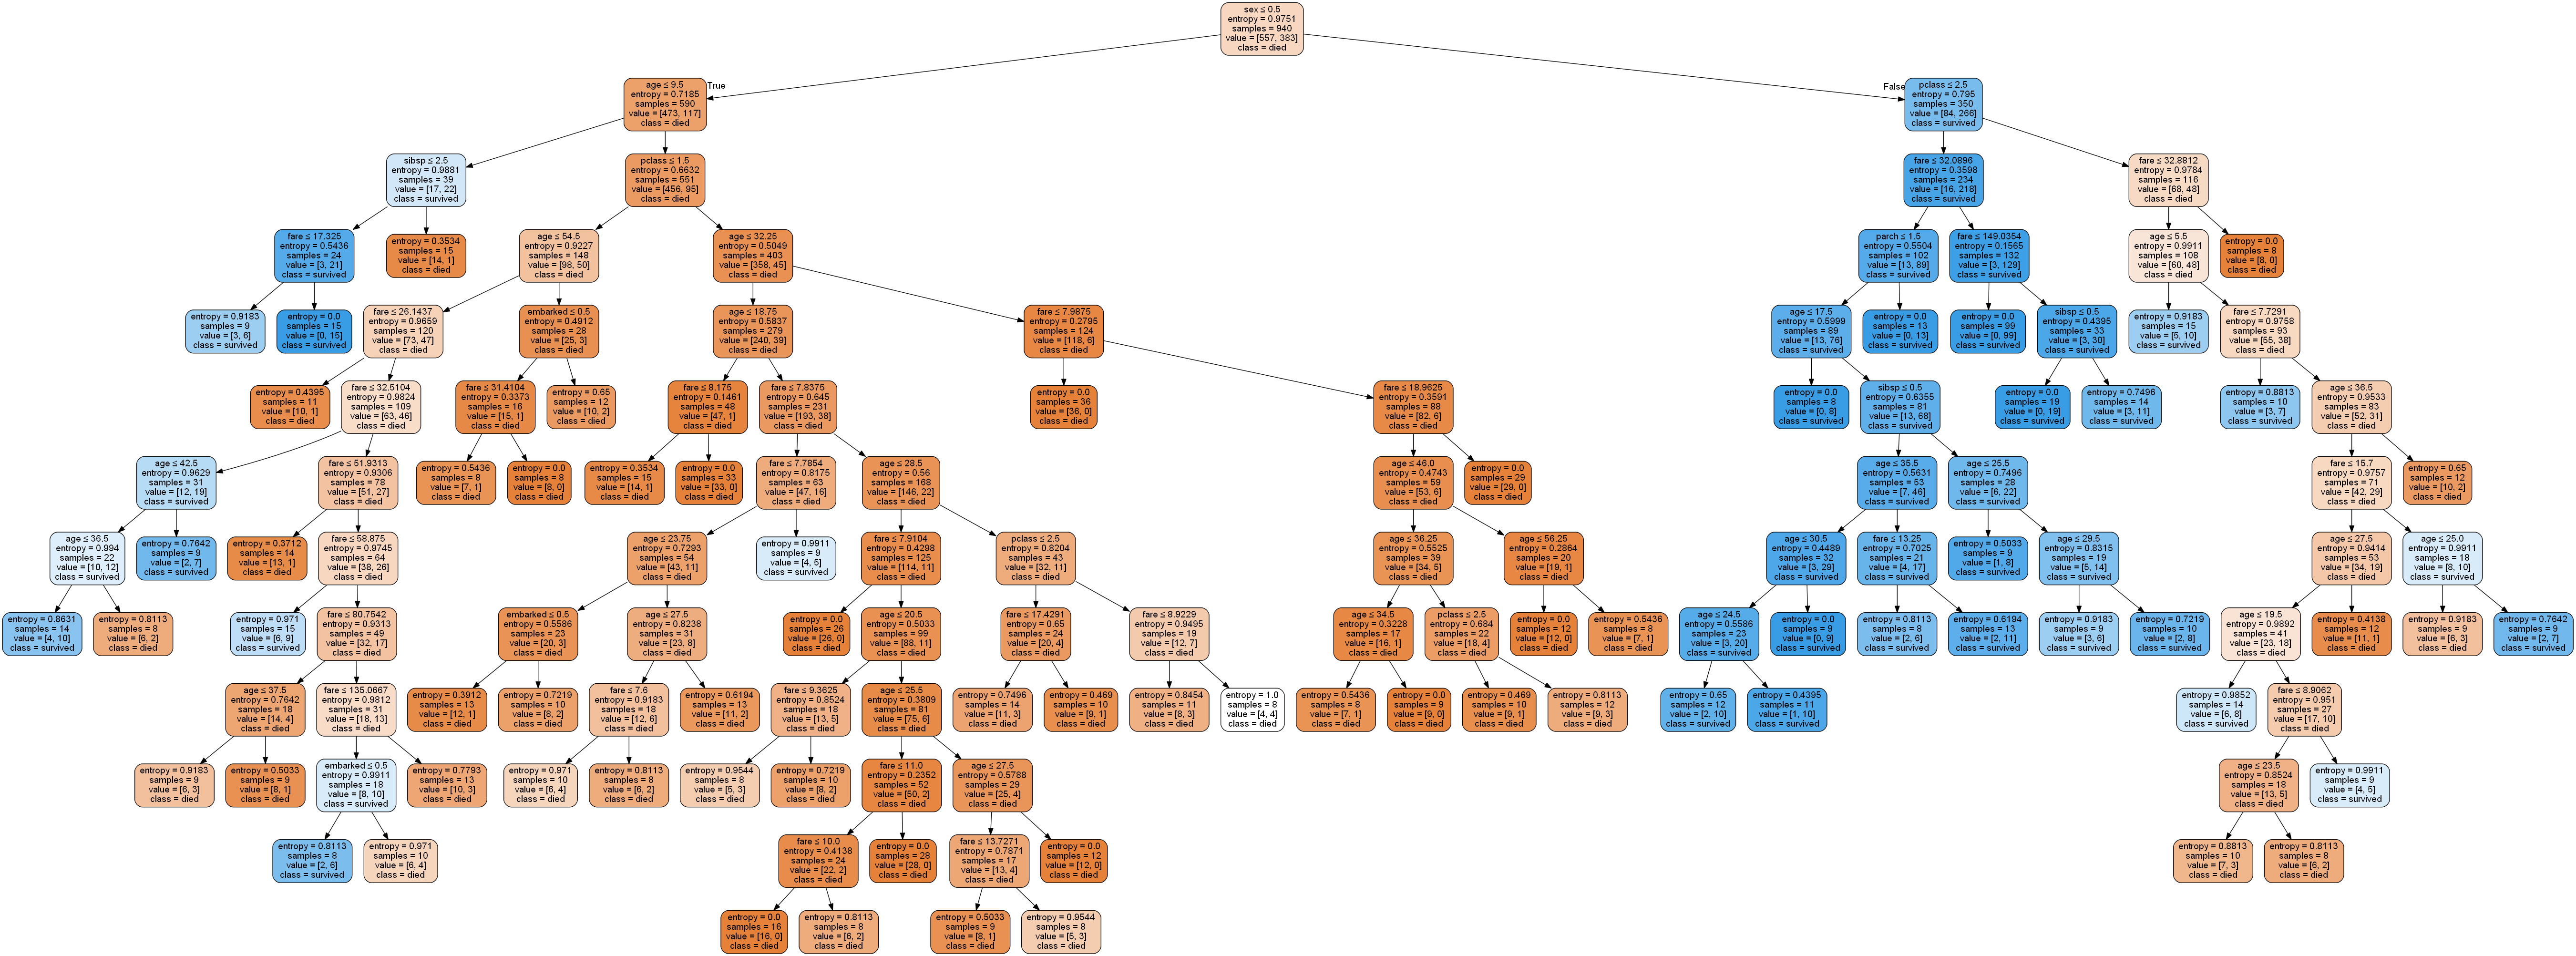

In [17]:
display(Image(graph.create_png()))

## Decision Tree Classifier on categorical values with numeric representation
### Grid Search
**Tuning hyper-parameters for accuracy**

In [18]:
# numeric
features = list(titanic_numeric.columns[1:])
titanic_y = titanic_numeric["survived"]
titanic_X = titanic_numeric[features]

dt = DecisionTreeClassifier()
dt.set_params(**grid_search(dt, titanic_X, titanic_y))

Best parameters found:
{'criterion': 'entropy', 'min_samples_leaf': 6, 'min_samples_split': 5, 'presort': 0}


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=5, min_weight_fraction_leaf=0.0, presort=0,
            random_state=None, splitter='best')

### Cross-Validation

In [19]:
cross_val(dt, 10, titanic_X, titanic_y)

dot_data = tree.export_graphviz(dt, out_file=None, feature_names=features, class_names=["died", "survived"],
                                filled=True, rounded=True, special_characters=True)


graph = pydotplus.graph_from_dot_data(dot_data)

Accuracy: 0.76 (+/- 0.11)
             precision    recall  f1-score   support

        0.0       0.77      0.85      0.81       618
        1.0       0.75      0.63      0.68       425

avg / total       0.76      0.76      0.76      1043



### Tree structure of the sklearn Decision Tree on numeric data
**double click to zoom**

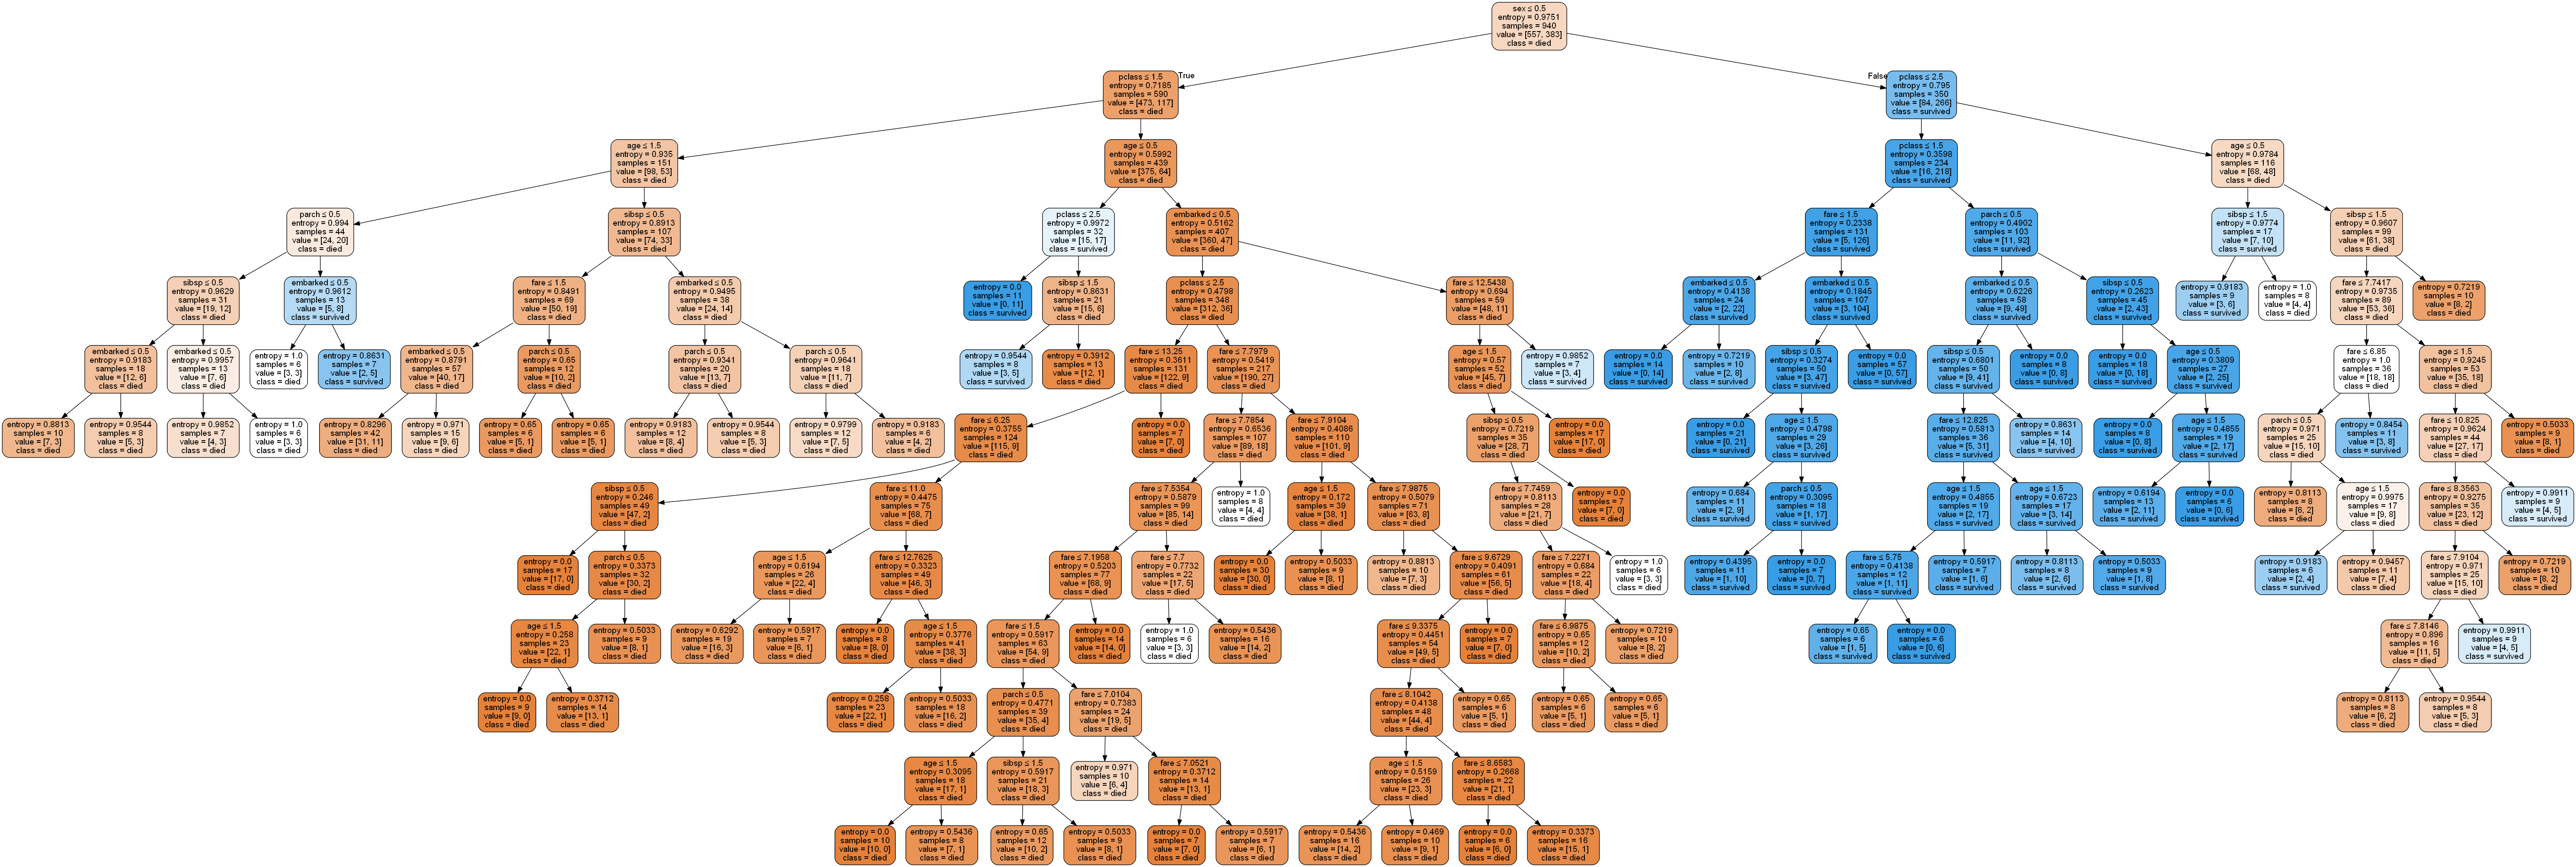

In [20]:
display(Image(graph.create_png()))

Text regarding Task 2:
- Compare the performance to an appropriate baseline
     - what is the baseline? sklearn is already "standard"
- Interpret and discuss feature importance
     - First (-> most important) split attirbute is "sex" -> just as predicted in Task 1
     - also highly ranked split attributes: "pclass", "age" -> also predicted in Task 1
-> "women and children first"

# Task 3: Own DecisionTree implementation

In [21]:
class DecisionTree(BaseEstimator):
    def __init__(self, measure_function="info_gain", demo_param='demo'):
        self.demo_param = demo_param
        self.calc_measure = None
        self.root = None
        self.measure_function = measure_function

    def fit(self, x, y):
        self.root = DecisionNode(x, y, self.measure_function)
        # Return the estimator
        return self

    def predict(self, x):
        y = self.root.traverse(x)
        return y

    def export_tree(self, name):
        graph_data = """digraph {} {{
            node [shape=box, style=\"rounded,filled\"]""".format(name)
        graph_data += self.root.export("0")
        graph_data += "}"
        return graph_data


class DecisionNode:
    def __init__(self, x, y, measure_function="info_gain"):
        self.attributes = x.columns
        self.data = x
        self.results = y
        self.children = None
        self.decision_attribute = y.name
        self.measure_function = measure_function
        self.calc_measure = self.information_gain
        if measure_function == "gini":
            self.calc_measure = self.gini
        self.measure_of_impurity = 0
        self.decision = y.value_counts().idxmax()
        self.split_attribute = ""
        self.decide()

    @staticmethod
    def information_gain(data, split_data):
        def log2(x):
            from math import log
            return log(x)/log(2)

        def entropy(t):
            results = t.value_counts()
            # Now calculate the entropy
            ent = 0
            for r in results.keys():
                p = float(results[r])/len(t)
                ent = ent-p*log2(p)
            return ent

        gain = entropy(data)
        for d in split_data:
            gain -= (len(d)/len(data)) * entropy(d)
        return gain

    @staticmethod
    def gini(data, split_data):
        gini_index = 0
        for d in split_data:
            l = (len(d)/len(data))
            decision_value_counts = d.value_counts().values
            gini_impurity = 1
            for d_v_c in decision_value_counts:
                gini_impurity -= d_v_c/len(d) * d_v_c/len(d)
            gini_index += l * gini_impurity
        return gini_index

    def divide_set(self, attribute):
        distinct_values = self.data[attribute].unique()
        datasets = []
        for v in distinct_values:
            datasets.append(self.results[self.data[attribute] == v])
        return datasets

    def decide(self):
        import sys
        deciding_measure_of_impurity = -sys.maxsize - 1
        if self.measure_function == "gini":
            deciding_measure_of_impurity = sys.maxsize
        best_attribute = ""
        for attribute in self.attributes:
            measure_of_impurity = self.calc_measure(self.results, self.divide_set(attribute))
            if self.measure_function == "gini":
                if deciding_measure_of_impurity > measure_of_impurity:
                    deciding_measure_of_impurity = measure_of_impurity
                    best_attribute = attribute
            else:
                if deciding_measure_of_impurity < measure_of_impurity:
                    deciding_measure_of_impurity = measure_of_impurity
                    best_attribute = attribute
        if deciding_measure_of_impurity > 0:
            self.split_attribute = best_attribute
            self.split(best_attribute)
            self.measure_of_impurity = deciding_measure_of_impurity

    def split(self, attribute):
        distinct_values = self.data[attribute].unique()
        if len(distinct_values) > 1:
            self.children = {}
            for v in distinct_values:
                child_node = DecisionNode(self.data[self.data[attribute] == v], self.results[self.data[attribute] == v],
                                          self.calc_measure)
                self.children[v] = child_node

    def export(self, node_id, decision_counts=None):
        if decision_counts is None:
            decision_counts = self.results.value_counts()
        values = decision_counts.copy()
        for r_i, r in decision_counts.iteritems():
            if r_i in self.results.value_counts(sort=False):
                values[r_i] = self.results.value_counts(sort=False)[r_i]
            else:
                values[r_i] = 0
        if self.children is None:
            node_data = """{} [color=lightblue, label=\"Measure of impurity: {}\lSamples: {}\lValues: {}\lDecision: {}\l\"]
            """.format(node_id, round(self.measure_of_impurity, 2), self.results.size, values.values, self.decision)
            return node_data
        else:
            node_data = """{} [label=\"Decision attribute: {}\lMeasure of impurity: {}\lSamples: {}\lValues: {}\lDecision: {}\l\"]
            """.format(node_id, self.split_attribute, round(self.measure_of_impurity, 5), self.results.size, values.values, self.decision)
            c_id = 0
            for e, c in self.children.items():
                c_id_str = node_id + str(c_id)
                node_data += c.export(c_id_str, decision_counts)
                node_data += "{} -> {} [label=\"{}\"]\n".format(node_id, c_id_str, e)
                c_id += 1
        return node_data + "\n"

    def traverse(self, x):
        results = np.array([])
        if self.children is None:
            results = np.append(results, [self.decision for x_i in range(len(x))])
        else:
            distinct_values = x[self.split_attribute].unique()
            if len(distinct_values) > 0:
                for v in distinct_values:
                    if v in self.children:
                        results = np.append(results, self.children[v].traverse(x[x[self.split_attribute] == v]))
                    else:
                        results = np.append(results, [self.decision for x_i in range(len(x[x[self.split_attribute] == v]
                                                                                         ))])
            else:
                results = np.append(results, [self.decision for x_i in range(len(x))])
        return results


features = list(titanic_categorical.columns[1:])
titanic_y = titanic_categorical["survived"]
titanic_X = titanic_categorical[features]

## with gini index as measure of impurity
### Cross-Validation

In [22]:
dt = DecisionTree(measure_function="gini")
cross_val(dt, 10, titanic_X, titanic_y)

Accuracy: 0.72 (+/- 0.18)
             precision    recall  f1-score   support

       died       0.74      0.81      0.78       618
   survived       0.68      0.59      0.63       425

avg / total       0.72      0.72      0.72      1043



### Tree structure of the our tree using gini and categorical values
**double click to zoom**

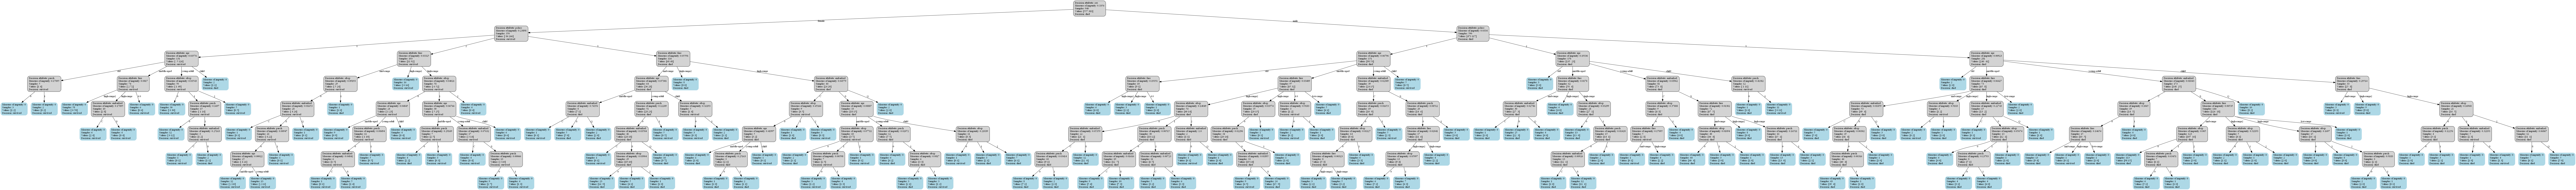

In [23]:
graph = pydotplus.graph_from_dot_data(dt.export_tree("Tree"))
display(Image(graph.create_png()))

## with information gain as measure of impurity
### Cross-Validation

In [24]:
dt = DecisionTree()
cross_val(dt, 10, titanic_X, titanic_y)

Accuracy: 0.72 (+/- 0.18)
             precision    recall  f1-score   support

       died       0.74      0.81      0.78       618
   survived       0.68      0.59      0.63       425

avg / total       0.72      0.72      0.72      1043



### Tree structure of the our tree using information gain and categorical values
**double click to zoom**

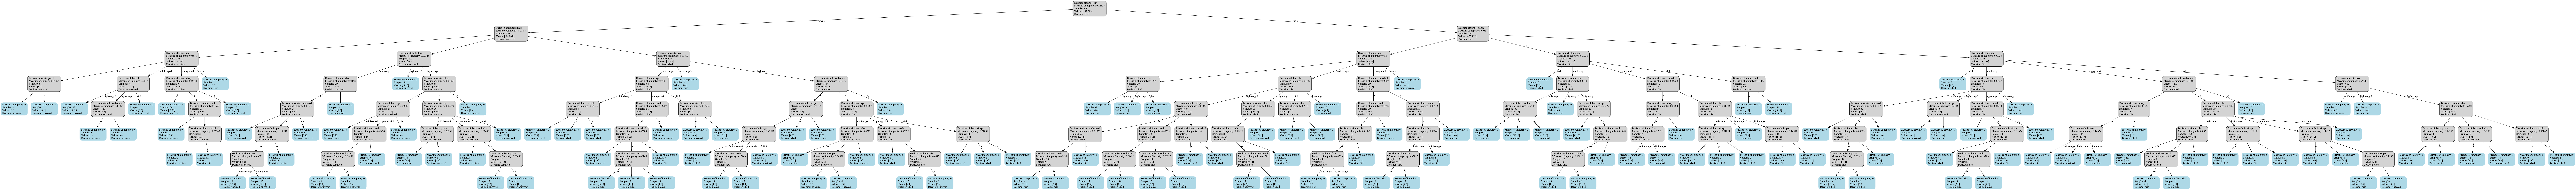

In [25]:
graph = pydotplus.graph_from_dot_data(dt.export_tree("Tree"))
display(Image(graph.create_png()))

### Comparison of results
- Our algorithm is way slower (Cause? Maybe: No "tree library" used)
- Our tree looks nicer because of non-binary splits
- accuracy is nearly as good as the accuracy form the sklearn classifier
- however, our standard deviation is a lot worse (+- 17- 19 % depending on preprocessing)
- binary splits seem to generate splits with better information gain or gini index
- Usually, one would use different preprocessing for the different implementations:
     - Our implementation uses categorical values and creates as many branches
       as there are different values for an attribute
        - Numerical values should be grouped in preprocessing
     - The sklearn implementation uses numerical values and finds thresholds
       for binary splits
        - Numerical values should be left as-is and categorical values
          have to be eliminated